# RT-DETR - Detection Transformer

RT-DETR repo: https://github.com/lyuwenyu/RT-DETR/tree/main/rtdetr_pytorch


In [1]:
!python --version

Python 3.9.0


In [2]:
!pip --version

pip 25.1 from C:\Users\ADMIN\.conda\envs\rtdetr\lib\site-packages\pip (python 3.9)



In [3]:
import torch
torch.__version__

'2.7.1+cu118'

In [4]:
import supervision as sv
import transformers

sv.__version__ , transformers.__version__

c:\Users\ADMIN\.conda\envs\rtdetr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('0.3.0', '4.53.0')

In [5]:
import pytorch_lightning
print(pytorch_lightning.__version__)

2.5.2


## Create COCO data loaders

### About dataset:

#### number of classes - 4  ['angle', 'fracture', 'line', 'messed_up_angle'


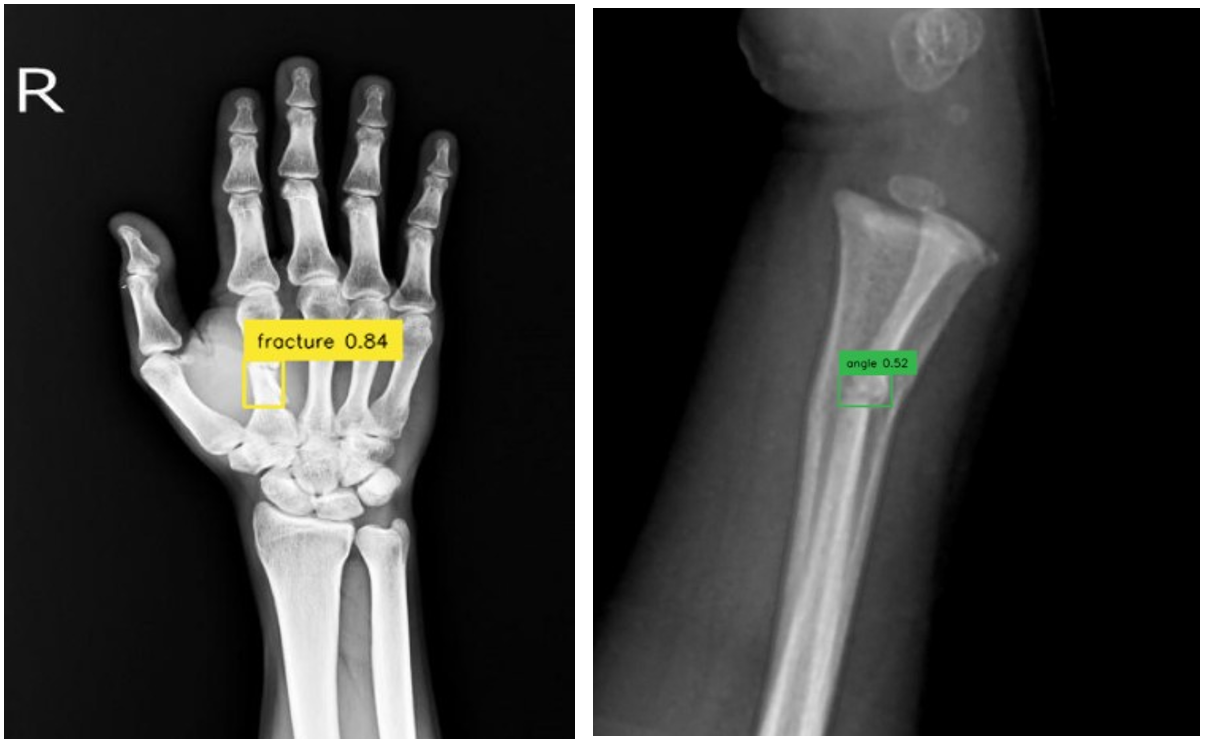]

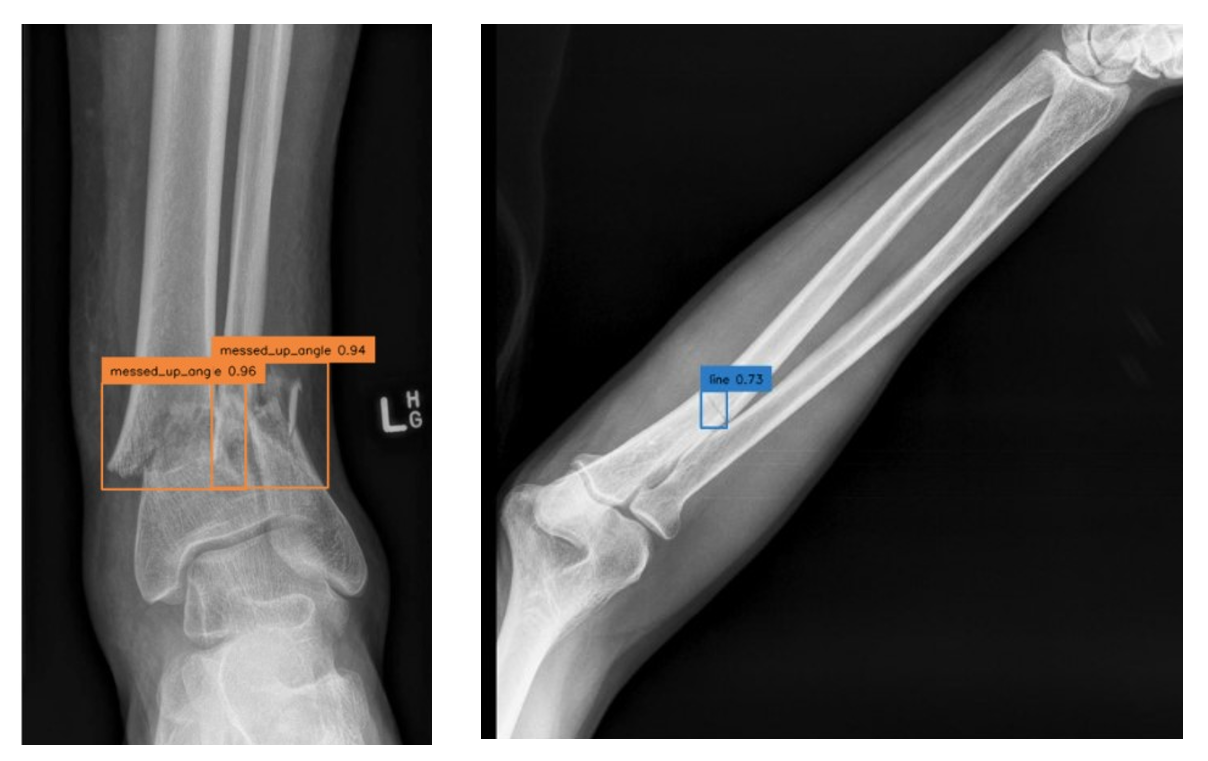

In [6]:
import os
import torchvision
from transformers import DetrImageProcessor
image_processor = DetrImageProcessor.from_pretrained("PekingU/rtdetr_r50vd")

dataset = 'D:\\ML Projects\\rtdetr\\bone fracture.v2-release.coco'

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of training examples: 326
Number of validation examples: 88
Number of test examples: 44


Image #224


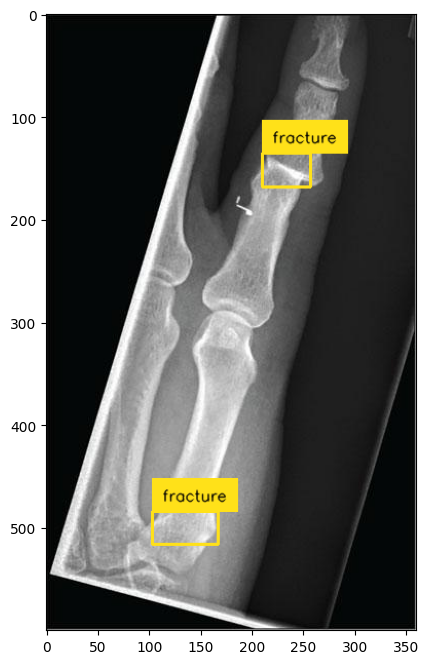

In [7]:
# Visualize if dataset is loaded properly

import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# annotate
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

# we will use id2label function for training
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (8, 8))

In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=4)

# Train model with PyTorch Lightning

The RT-DETR model is loaded using the Hugging Face Transformers library

In [9]:
import pytorch_lightning as pl
from transformers import RTDetrForObjectDetection
import torch


class RTDetrLightning(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay, id2label):
        super().__init__()
        self.save_hyperparameters()  # For reproducibility

        self.model = RTDetrForObjectDetection.from_pretrained(
            pretrained_model_name_or_path="PekingU/rtdetr_r50vd",
            num_labels=len(id2label),
            id2label=id2label,
            label2id={v: k for k, v in id2label.items()},
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def on_train_start(self) -> None:
        ds = self.train_dataloader().dataset  # your CocoDetection instance
        print(f"Training on dataset root: {ds.root}")
        # show 5 random images that will actually be loaded
        import random
        sample_ids = random.sample(ds.ids, 5)
        for img_id in sample_ids:
            fn = ds.coco.loadImgs(img_id)[0]["file_name"]
            print(" ", os.path.join(ds.root, fn))

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())
        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
        return loss

    def configure_optimizers(self):
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]
            },
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER


In [10]:
import os
import torch
from dotenv import load_dotenv
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor
from PIL import Image

# 0. Setup
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
load_dotenv()
hf_token = os.getenv("HF_TOKEN")
assert hf_token, "HF_TOKEN missing in .env!"

# 1. Rebuild your id2label map from the COCO train set
categories = TRAIN_DATASET.coco.cats
id2label   = {int(k): v["name"] for k, v in categories.items()}
label2id   = {v: k for k, v in id2label.items()}

# 2. Load the RT-DETR processor & the raw HF model  
#    (we’ll bypass the LightningModule’s `.model` here for simplicity)
processor = RTDetrImageProcessor.from_pretrained(
    "PekingU/rtdetr_r50vd",
    use_auth_token=hf_token
)
hf_model = RTDetrForObjectDetection.from_pretrained(
    "PekingU/rtdetr_r50vd",
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    use_auth_token=hf_token
).to(DEVICE)
hf_model.eval()

# 3. Load a single image from your COCO train folder
img_file = next(os.scandir(TRAIN_DIRECTORY)).name
image    = Image.open(os.path.join(TRAIN_DIRECTORY, img_file)).convert("RGB")

# 4. Preprocess → this gives BOTH pixel_values & pixel_mask
# 4. Preprocess → pad & get both pixel_values & pixel_mask
inputs = processor(
    images=image,
    return_tensors="pt",
    do_pad=True,            # ← pad to square
    return_pixel_mask=True, # ← ensure a mask is created
).to(DEVICE)

# 5. Inference → now both required args are present
outputs = hf_model(
    pixel_values=inputs["pixel_values"],
    pixel_mask  =inputs["pixel_mask"],
)


# 6. Post-process back to original image size
target_sizes = torch.tensor([[image.height, image.width]], device=DEVICE)
results = processor.post_process_object_detection(
    outputs,
    threshold=0.5,
    target_sizes=target_sizes
)[0]

# 7. Print your detections
print(f"Detections for {img_file}:")
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    cls_name = id2label[int(label)]
    box = [round(x, 1) for x in box.tolist()]
    print(f" • {cls_name:<12s} {score:.2f}  box={box}")


c:\Users\ADMIN\.conda\envs\rtdetr\lib\site-packages\transformers\image_processing_base.py:193: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
c:\Users\ADMIN\.conda\envs\rtdetr\lib\site-packages\transformers\modeling_utils.py:4445: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoi

Detections for 101_jpg.rf.01df1023e27cc86113edc3d17e5d9849.jpg:
 • angle        0.72  box=[0.1, 7.5, 993.0, 1012.9]
 • angle        0.70  box=[-0.5, -2.1, 992.3, 1021.8]
 • angle        0.69  box=[6.5, 0.4, 29.9, 147.0]
 • fracture     0.69  box=[1.7, 8.3, 994.7, 1007.2]
 • angle        0.69  box=[0.0, -10.2, 993.0, 1013.8]
 • angle        0.68  box=[-0.3, -2.6, 992.7, 1021.3]
 • angle        0.68  box=[7.2, 1.7, 41.2, 188.3]
 • angle        0.68  box=[1.7, 8.3, 994.7, 1007.2]
 • angle        0.68  box=[6.7, 10.2, 21.3, 173.5]
 • angle        0.67  box=[2.4, -1.1, 995.4, 970.9]
 • angle        0.67  box=[7.0, 0.2, 21.2, 161.4]
 • angle        0.66  box=[-2.2, -94.6, 990.8, 912.8]
 • angle        0.66  box=[1.2, -59.6, 994.2, 963.8]
 • fracture     0.66  box=[2.4, -1.1, 995.4, 970.9]
 • angle        0.66  box=[0.6, -66.0, 993.5, 958.0]
 • angle        0.65  box=[-2.2, -38.9, 990.8, 985.0]
 • angle        0.65  box=[1.0, -14.7, 991.2, 890.7]
 • fracture     0.65  box=[1.2, -59.6, 994.2, 

In [11]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# 1) Build your LightningModule (already loads the pretrained RT-DETR under the hood)
pl_model = RTDetrLightning(
    lr=1e-4,
    lr_backbone=1e-5,
    weight_decay=1e-4,
    id2label=id2label
)

# 2) Set up callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="validation/loss",
    mode="min",
    save_top_k=1,
    filename="best-ckpt",
    verbose=True
)
early_stopping = EarlyStopping(
    monitor="validation/loss",
    patience=10,
    mode="min",
    verbose=True
)

# 3) Trainer
trainer = Trainer(
    max_epochs=100,
    accelerator="auto",
    devices=1,
    gradient_clip_val=0.1,
    accumulate_grad_batches=8,
    log_every_n_steps=5,
    callbacks=[checkpoint_callback, early_stopping]
)

# 4) Fit
trainer.fit(pl_model)


Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.cl

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ADMIN\.conda\envs\rtdetr\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00,  3.40it/s]

c:\Users\ADMIN\.conda\envs\rtdetr\lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


c:\Users\ADMIN\.conda\envs\rtdetr\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]Training on dataset root: D:\ML Projects\rtdetr\bone fracture.v2-release.coco\train
  D:\ML Projects\rtdetr\bone fracture.v2-release.coco\train\132_jpg.rf.c92ce7cd5432fabe6f7c1c91c31c4f42.jpg
  D:\ML Projects\rtdetr\bone fracture.v2-release.coco\train\34_jpg.rf.75c88e6db5553b8d02d02b36d672b7e7.jpg
  D:\ML Projects\rtdetr\bone fracture.v2-release.coco\train\69_jpg.rf.8edfc20839445f366c94a85f8b2a3b74.jpg
  D:\ML Projects\rtdetr\bone fracture.v2-release.coco\train\161_jpg.rf.ef60cb59cc4bbd45d0fa8249dc975ff4.jpg
  D:\ML Projects\rtdetr\bone fracture.v2-release.coco\train\45_jpg.rf.856fd0b4a42c851bc1d5a955a6d2ffe6.jpg
Epoch 0: 100%|██████████| 82/82 [12:49<00:00,  0.11it/s, v_num=3]

Metric validation/loss improved. New best score: 58.943
Epoch 0, global step 11: 'validation/loss' reached 58.94257 (best 58.94257), saving model to 'd:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\\best-ckpt.ckpt' as top 1


Epoch 1: 100%|██████████| 82/82 [13:39<00:00,  0.10it/s, v_num=3]

Epoch 1, global step 22: 'validation/loss' was not in top 1


Epoch 2: 100%|██████████| 82/82 [13:38<00:00,  0.10it/s, v_num=3]

Epoch 2, global step 33: 'validation/loss' was not in top 1


Epoch 3: 100%|██████████| 82/82 [13:37<00:00,  0.10it/s, v_num=3]

Metric validation/loss improved by 32.486 >= min_delta = 0.0. New best score: 26.456
Epoch 3, global step 44: 'validation/loss' reached 26.45627 (best 26.45627), saving model to 'd:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\\best-ckpt.ckpt' as top 1


Epoch 4: 100%|██████████| 82/82 [13:15<00:00,  0.10it/s, v_num=3]

Metric validation/loss improved by 5.756 >= min_delta = 0.0. New best score: 20.700
Epoch 4, global step 55: 'validation/loss' reached 20.70032 (best 20.70032), saving model to 'd:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\\best-ckpt.ckpt' as top 1


Epoch 5: 100%|██████████| 82/82 [13:45<00:00,  0.10it/s, v_num=3]

Metric validation/loss improved by 2.333 >= min_delta = 0.0. New best score: 18.367
Epoch 5, global step 66: 'validation/loss' reached 18.36746 (best 18.36746), saving model to 'd:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\\best-ckpt.ckpt' as top 1


Epoch 6: 100%|██████████| 82/82 [13:22<00:00,  0.10it/s, v_num=3]

Metric validation/loss improved by 1.337 >= min_delta = 0.0. New best score: 17.031
Epoch 6, global step 77: 'validation/loss' reached 17.03095 (best 17.03095), saving model to 'd:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\\best-ckpt.ckpt' as top 1


Epoch 7: 100%|██████████| 82/82 [16:05<00:00,  0.08it/s, v_num=3]

Metric validation/loss improved by 0.756 >= min_delta = 0.0. New best score: 16.275
Epoch 7, global step 88: 'validation/loss' reached 16.27500 (best 16.27500), saving model to 'd:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\\best-ckpt.ckpt' as top 1


Epoch 8: 100%|██████████| 82/82 [16:35<00:00,  0.08it/s, v_num=3]

Metric validation/loss improved by 0.019 >= min_delta = 0.0. New best score: 16.256
Epoch 8, global step 99: 'validation/loss' reached 16.25649 (best 16.25649), saving model to 'd:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\\best-ckpt.ckpt' as top 1


Epoch 9: 100%|██████████| 82/82 [16:56<00:00,  0.08it/s, v_num=3]

Epoch 9, global step 110: 'validation/loss' was not in top 1


Epoch 10: 100%|██████████| 82/82 [16:38<00:00,  0.08it/s, v_num=3]

Metric validation/loss improved by 0.523 >= min_delta = 0.0. New best score: 15.733
Epoch 10, global step 121: 'validation/loss' reached 15.73350 (best 15.73350), saving model to 'd:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\\best-ckpt.ckpt' as top 1


Epoch 11: 100%|██████████| 82/82 [16:26<00:00,  0.08it/s, v_num=3]

Metric validation/loss improved by 0.285 >= min_delta = 0.0. New best score: 15.449
Epoch 11, global step 132: 'validation/loss' reached 15.44875 (best 15.44875), saving model to 'd:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\\best-ckpt.ckpt' as top 1


Epoch 12: 100%|██████████| 82/82 [15:58<00:00,  0.09it/s, v_num=3]

Epoch 12, global step 143: 'validation/loss' was not in top 1


Epoch 13: 100%|██████████| 82/82 [16:26<00:00,  0.08it/s, v_num=3]

Epoch 13, global step 154: 'validation/loss' was not in top 1


Epoch 14: 100%|██████████| 82/82 [16:05<00:00,  0.08it/s, v_num=3]

Epoch 14, global step 165: 'validation/loss' was not in top 1


Epoch 15: 100%|██████████| 82/82 [16:19<00:00,  0.08it/s, v_num=3]

Epoch 15, global step 176: 'validation/loss' was not in top 1


Epoch 16: 100%|██████████| 82/82 [16:19<00:00,  0.08it/s, v_num=3]

Epoch 16, global step 187: 'validation/loss' was not in top 1


Epoch 17: 100%|██████████| 82/82 [16:22<00:00,  0.08it/s, v_num=3]

Epoch 17, global step 198: 'validation/loss' was not in top 1


Epoch 18: 100%|██████████| 82/82 [15:10<00:00,  0.09it/s, v_num=3]

Epoch 18, global step 209: 'validation/loss' was not in top 1


Epoch 19: 100%|██████████| 82/82 [14:40<00:00,  0.09it/s, v_num=3]

Epoch 19, global step 220: 'validation/loss' was not in top 1


Epoch 20: 100%|██████████| 82/82 [16:41<00:00,  0.08it/s, v_num=3]

Epoch 20, global step 231: 'validation/loss' was not in top 1


Epoch 21: 100%|██████████| 82/82 [16:11<00:00,  0.08it/s, v_num=3]

Monitored metric validation/loss did not improve in the last 10 records. Best score: 15.449. Signaling Trainer to stop.
Epoch 21, global step 242: 'validation/loss' was not in top 1


Epoch 21: 100%|██████████| 82/82 [16:11<00:00,  0.08it/s, v_num=3]


# Inference on test dataset

Let's visualize the predictions of DETR on the first image of the test set.

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.cl

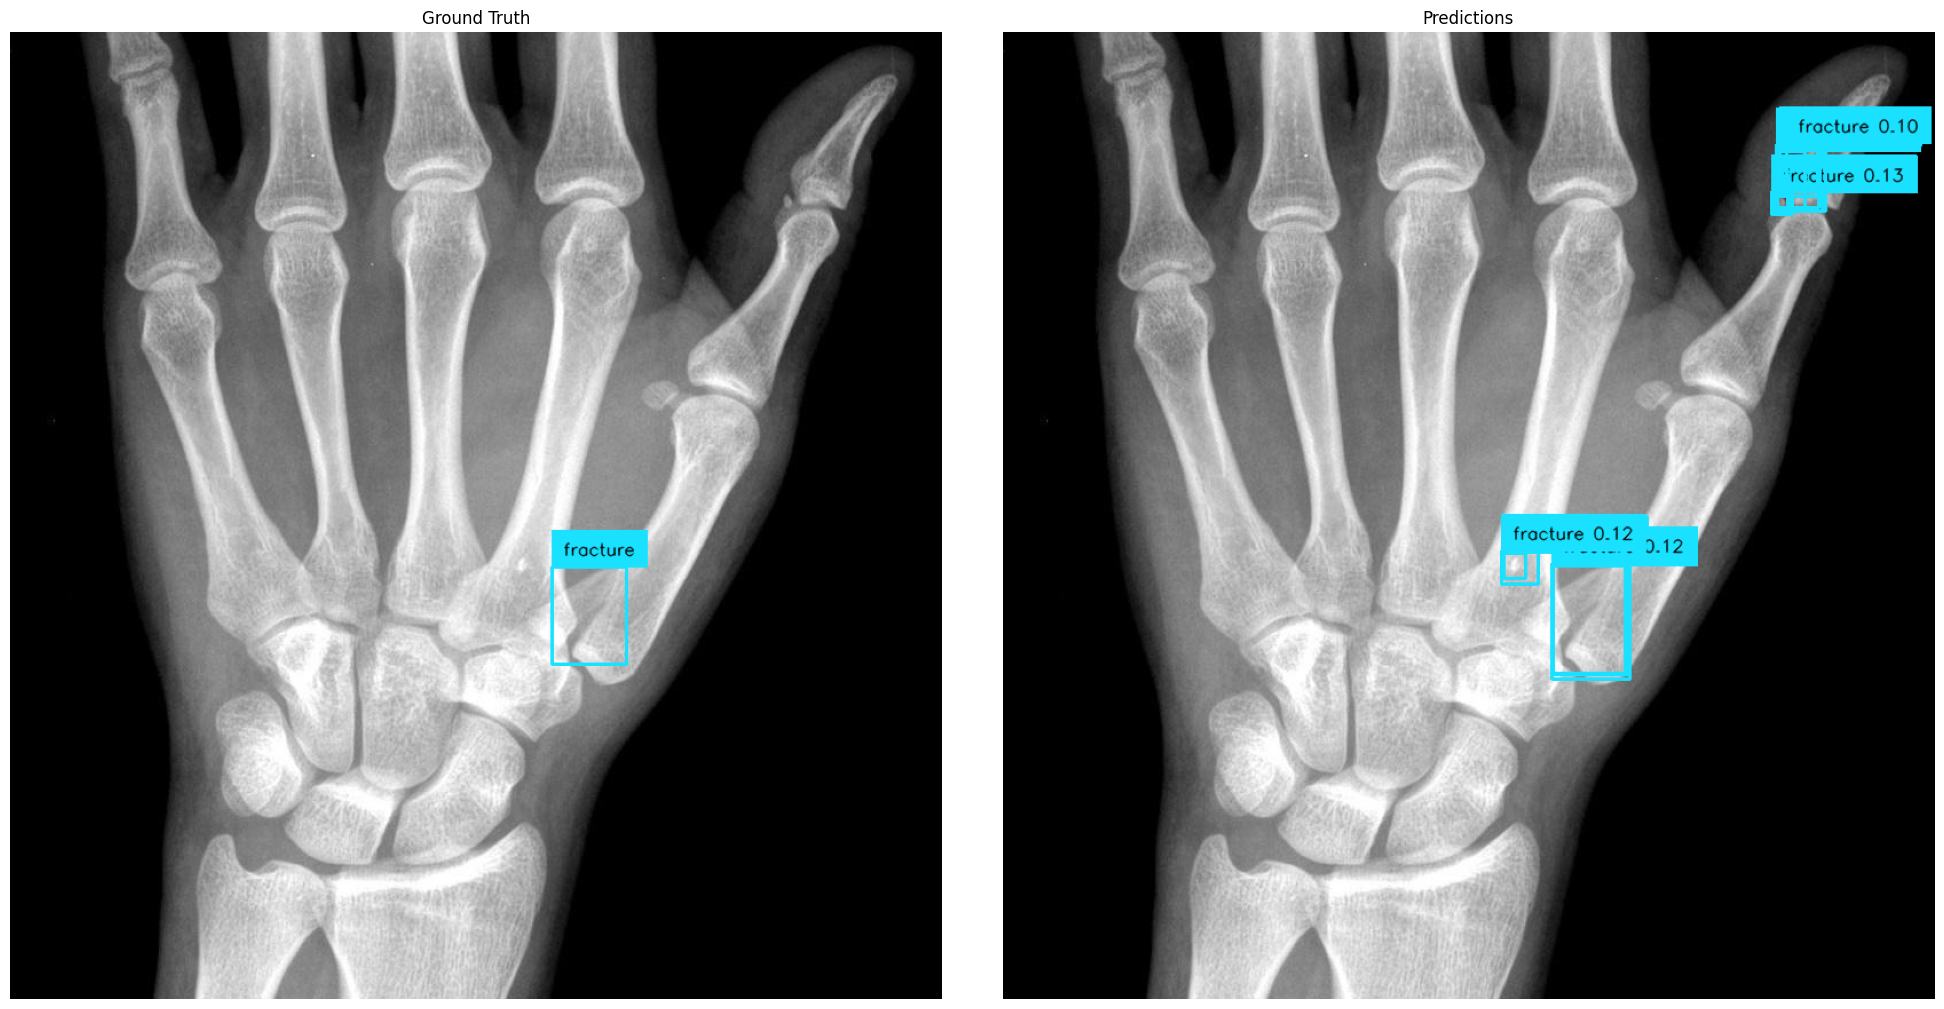

In [20]:
import os
import random

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv
from transformers import RTDetrImageProcessor

# — Config —
CONF_THRESHOLD   = 0.1
CHECKPOINT_PATH  = r"D:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\best-ckpt.ckpt"
DEVICE           = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# — 1. Load LightningModule (with its hparams) —
lit_model = RTDetrLightning.load_from_checkpoint(CHECKPOINT_PATH)
hf_model  = lit_model.model     # this is your RTDetrForObjectDetection
hf_model.to(DEVICE).eval()

# — 2. Prepare the processor & category maps —
processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r50vd")
cats      = TEST_DATASET.coco.cats
id2label  = {k: v["name"] for k, v in cats.items()}

# — 3. Box annotator —
annotator = sv.BoxAnnotator()

# — 4. Pick a random annotated test image —
all_ids       = TEST_DATASET.coco.getImgIds()
annotated_ids = [i for i in all_ids if len(TEST_DATASET.coco.imgToAnns[i]) > 0]
image_id      = random.choice(annotated_ids)
meta          = TEST_DATASET.coco.loadImgs(image_id)[0]
anns          = TEST_DATASET.coco.imgToAnns[image_id]
img_path      = os.path.join(TEST_DATASET.root, meta["file_name"])
bgr           = cv2.imread(img_path)
rgb           = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

# — 5. Draw ground truth —
gt = sv.Detections.from_coco_annotations(coco_annotation=anns)
gt_labels = [id2label[cid] for _, _, cid, _ in gt]
frame_gt  = annotator.annotate(scene=rgb.copy(), detections=gt, labels=gt_labels)

# — 6. Inference & draw predictions —
with torch.no_grad():
    inputs  = processor(images=rgb, return_tensors="pt").to(DEVICE)
    outputs = hf_model(**inputs)
    target_sizes = torch.tensor([rgb.shape[:2]]).to(DEVICE)
    results = processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONF_THRESHOLD,
        target_sizes=target_sizes
    )[0]

pred = sv.Detections.from_transformers(transformers_results=results)
pred_labels = [f"{id2label[cid]} {conf:.2f}" for _, conf, cid, _ in pred]
frame_pred  = annotator.annotate(scene=rgb.copy(), detections=pred, labels=pred_labels)

# — 7. Show side-by-side —
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(frame_gt);   ax1.axis("off"); ax1.set_title("Ground Truth")
ax2.imshow(frame_pred); ax2.axis("off"); ax2.set_title("Predictions")
plt.tight_layout()
plt.show()


In [22]:
from transformers import RTDetrImageProcessor
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os, cv2, torch

# 1) Paths & setup
CHECKPOINT = r"D:\\ML Projects\\rtdetr\\lightning_logs\\version_3\\checkpoints\best-ckpt.ckpt"
TEST_DIR   = TEST_DATASET.root
ANN_FILE   = os.path.join(TEST_DIR, "_annotations.coco.json")
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CONF_THRESH= 0.05

# 2) Restore your LightningModule
lit = RTDetrLightning.load_from_checkpoint(CHECKPOINT)
model = lit.model   # this is the HF RTDetrForObjectDetection inside your LightningModule
model.to(DEVICE).eval()

# 3) Prepare processor & COCO GT
processor = RTDetrImageProcessor.from_pretrained("PekingU/rtdetr_r50vd")
coco_gt   = COCO(ANN_FILE)
img_ids   = coco_gt.getImgIds()

# 4) Inference loop → collect detections
coco_dets = []
for img_id in img_ids:
    info  = coco_gt.loadImgs(img_id)[0]
    img_p = os.path.join(TEST_DIR, info["file_name"])
    bgr   = cv2.imread(img_p)
    rgb   = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        inputs  = processor(images=rgb, return_tensors="pt").to(DEVICE)
        outputs = model(**inputs)

    target_sizes = torch.tensor([rgb.shape[:2]]).to(DEVICE)
    res = processor.post_process_object_detection(
        outputs=outputs,
        threshold=CONF_THRESH,
        target_sizes=target_sizes
    )[0]

    boxes  = res["boxes"].cpu().numpy()
    scores = res["scores"].cpu().numpy()
    labels = res["labels"].cpu().numpy()
    for box, score, label in zip(boxes, scores, labels):
        x1,y1,x2,y2 = box.tolist()
        coco_dets.append({
            "image_id":    img_id,
            "category_id": int(label),
            "bbox":        [x1, y1, x2-x1, y2-y1],
            "score":       float(score),
        })

# 5) COCOeval
coco_dt   = coco_gt.loadRes(coco_dets)
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.params.imgIds = img_ids
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.cl

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.059
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.162
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.043
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.157
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.289
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets